In [3]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
SYMBOLS = ['BrentOil', 'Copper', 'CrudeOil', 'Gasoline', 'Gold', 'NaturalGas', 'Platinum', 'Silver',
           'AUD', 'CNY', 'EUR', 'GBP', 'HKD', 'JPY', 'USD'] 


In [5]:
# 데이터 디렉토리 설정
data_dir = 'data'


# EDA

In [6]:
def preprocess_data(table, in_columns, out_columns):
    
    table.dropna(inplace=True, subset=['USD_Price', 'Gold_Price', 'Silver_Price'])
    table.interpolate(method='linear', inplace=True)
    

    if 'USD_Price' not in out_columns:
        raise ValueError('USD_Price must be included in out_columns')

    use_columns = list(set(in_columns + out_columns))
    df = table[use_columns]

    #새로운 파생변수 MACD 사용
    def calculate_macd(data, short_window, long_window, signal_window):
        short_ema = data.ewm(span=short_window, adjust=False).mean()
        long_ema = data.ewm(span=long_window, adjust=False).mean()
        macd = short_ema - long_ema
        signal_line = macd.ewm(span=signal_window, adjust=False).mean()
        return macd, signal_line

    df['MACD'], df['Signal_Line'] = calculate_macd(df['USD_Price'], short_window=12, long_window=26, signal_window=9)
    in_columns.extend(['MACD', 'Signal_Line'])
    #새로운 파생변서 RSI 사용
    def calculate_rsi(data, window):
        delta = data.diff()
        up, down = delta.copy(), delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        rs = up.rolling(window=window).mean() / down.abs().rolling(window=window).mean()
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['RSI'] = calculate_rsi(df['USD_Price'], window=14)
    df['RSI'] = df['RSI'].interpolate(method='linear', limit_direction='both')
    in_columns.append('RSI')

    def calculate_volatility(data, window):
        return data.rolling(window=window).std()
    #새로운 파생변수 변동성 사용
    df['Volatility'] = calculate_volatility(df['USD_Price'], window=20)
    df['Volatility'] = df['Volatility'].interpolate(method='linear', limit_direction='both')
    in_columns.append('Volatility')

    # print(df.shape)
    # print(df.head())
    # missing_values = df.isnull().sum()
    # print(missing_values)
    # total_missing_columns = missing_values[missing_values > 0].count()
    # print(f"Number of columns with missing values: {total_missing_columns}")
    # total_missing_rows = df.isnull().any(axis=1).sum()
    # print(f"Number of rows with missing values: {total_missing_rows}")

    return df
    



In [7]:
def merge_data(start_date, end_date, symbols, data_dir='data'):
    dates = pd.date_range(start_date, end_date, freq='D')
    
    df = pd.DataFrame(index=dates)


    if 'USD' not in symbols:
        symbols.insert(0, 'USD')

    for symbol in symbols:
        df_temp = pd.read_csv(get_data_path(symbol, data_dir), index_col="Date", parse_dates=True, na_values=['nan'])
        df_temp = df_temp.reindex(dates)
        df_temp.columns = [symbol + '_' + col for col in df_temp.columns]
        df = df.join(df_temp)

    return df


In [8]:
# 데이터 로드 및 전처리 테스트
start_date = '2013-01-01'
end_date = '2023-10-27'

# in_columns = ['USD_Price', 'Gold_Price', 'Silver_Price']
in_columns=['USD_Price','BrentOil_Price', 'Copper_Price', 'CrudeOil_Price', 'Gasoline_Price', 'Gold_Price', 
                             'NaturalGas_Price', 'Platinum_Price', 'Silver_Price', 'AUD_Price', 
                             'CNY_Price', 'EUR_Price', 'GBP_Price', 'HKD_Price', 'JPY_Price']
out_columns = ['USD_Price']



In [9]:
def get_data_path(symbol, data_dir):
    file_path = os.path.join(data_dir,f'{symbol}.csv')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No data file found for symbol: {symbol}")
    return file_path

In [10]:
# 데이터 병합
table = merge_data(start_date, end_date, symbols=SYMBOLS, data_dir=data_dir)



In [11]:
# 데이터 전처리
df = preprocess_data(table, in_columns, out_columns)

In [12]:
df

,Gasoline_Price,JPY_Price,NaturalGas_Price,Gold_Price,Copper_Price,Silver_Price,AUD_Price,HKD_Price,BrentOil_Price,Platinum_Price,EUR_Price,CNY_Price,CrudeOil_Price,GBP_Price,USD_Price,MACD,Signal_Line,RSI,Volatility
2013-01-02,2.7951,12.1898,3.233,1688.8,3.7360,31.007,1116.36,137.210,112.47,1571.50,1402.38,170.70,93.12,1728.61,1063.50,0.000000,0.000000,50.386473,9.274339
2013-01-03,2.7977,12.1864,3.198,1674.6,3.7170,30.720,1112.26,137.175,112.14,1555.15,1387.43,170.65,92.92,1711.86,1063.20,-0.023932,-0.004786,50.386473,9.274339
2013-01-04,2.7643,12.0486,3.287,1648.9,3.6935,29.946,1113.60,137.075,111.31,1560.80,1388.70,170.51,93.09,1707.05,1062.39,-0.107024,-0.025234,50.386473,9.274339
2013-01-07,2.7774,12.1059,3.266,1646.3,3.6780,30.082,1116.32,137.140,111.40,1561.10,1394.12,170.68,93.19,1713.07,1063.21,-0.105492,-0.041286,50.386473,9.274339
2013-01-08,2.7944,12.2155,3.218,1662.2,3.6720,30.465,1117.73,137.295,111.94,1582.35,1392.49,170.97,93.15,1708.60,1064.15,-0.028104,-0.038649,50.386473,9.274339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-23,2.3116,8.9636,2.926,1978.2,3.5865,23.095,850.23,171.540,88.69,905.00,1431.77,183.45,85.49,1643.83,1342.12,3.819118,4.954530,35.757212,5.600977
2023-10-24,2.2527,8.9640,2.971,1986.1,3.6240,23.116,854.04,171.770,87.16,891.90,1422.90,183.82,83.74,1634.02,1343.88,3.170452,4.597715,43.425076,5.706226
2023-10-25,2.2688,9.0007,3.010,1994.9,3.5910,23.007,853.12,172.900,89.12,912.40,1428.58,184.81,85.39,1637.94,1352.44,3.308957,4.339963,55.461638,5.625966
2023-10-26,2.2371,8.9934,3.214,1997.4,3.5845,22.908,855.04,172.960,87.05,909.00,1428.44,184.88,83.21,1640.27,1352.69,3.399706,4.151912,56.660073,5.676216


In [13]:
df.columns

Index(['Gasoline_Price', 'JPY_Price', 'NaturalGas_Price', 'Gold_Price',
       'Copper_Price', 'Silver_Price', 'AUD_Price', 'HKD_Price',
       'BrentOil_Price', 'Platinum_Price', 'EUR_Price', 'CNY_Price',
       'CrudeOil_Price', 'GBP_Price', 'USD_Price', 'MACD', 'Signal_Line',
       'RSI', 'Volatility'],
      dtype='object')

In [14]:
missing_values = df.isnull().sum()
print(missing_values)

Gasoline_Price      0
JPY_Price           0
NaturalGas_Price    0
Gold_Price          0
Copper_Price        0
Silver_Price        0
AUD_Price           0
HKD_Price           0
BrentOil_Price      0
Platinum_Price      0
EUR_Price           0
CNY_Price           0
CrudeOil_Price      0
GBP_Price           0
USD_Price           0
MACD                0
Signal_Line         0
RSI                 0
Volatility          0
dtype: int64


In [15]:
# 전체 데이터에서 결측치가 있는 컬럼의 수를 확인
total_missing_columns = missing_values[missing_values > 0].count()
print(f"Number of columns with missing values: {total_missing_columns}")

# 결측치가 있는 행의 수를 확인
total_missing_rows = df.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {total_missing_rows}")

Number of columns with missing values: 0
Number of rows with missing values: 0


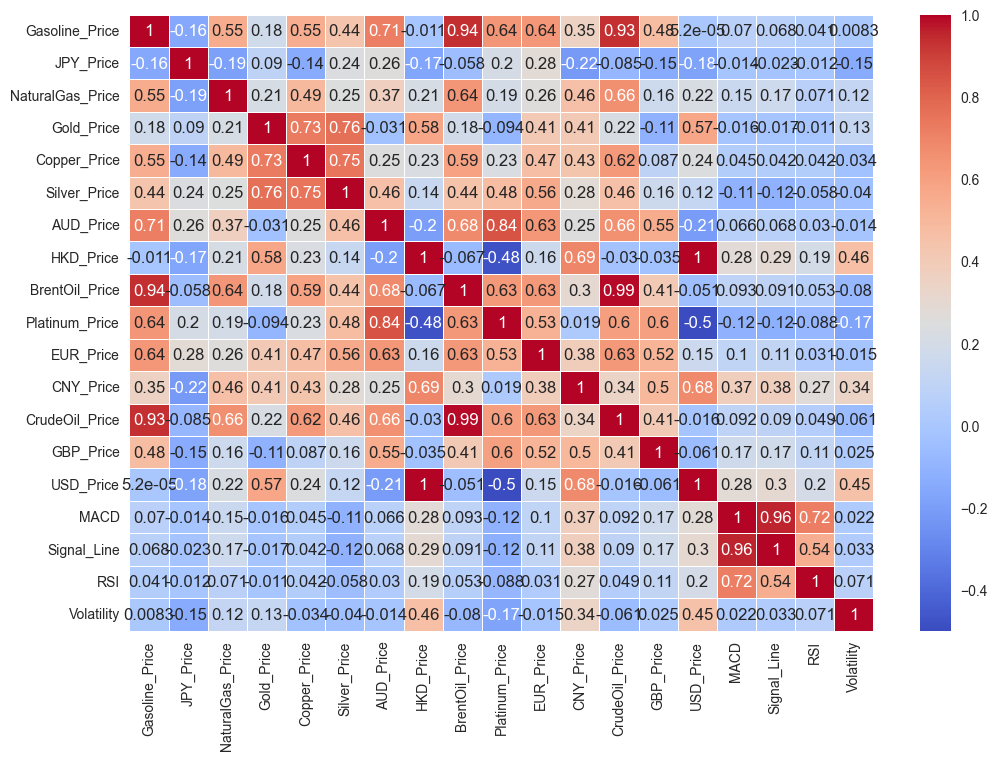

In [16]:
#상관관계 시각화
plt.figure(figsize=(12, 8))  # 히트맵의 크기 설정
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()
#plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

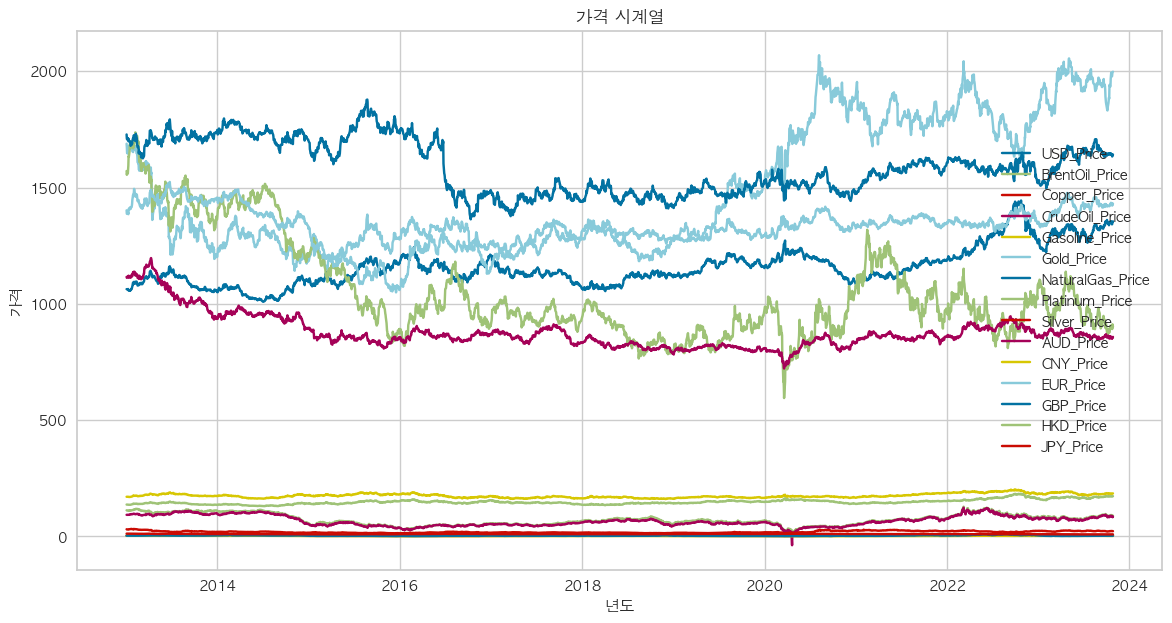

In [17]:
plt.figure(figsize=(14, 7))
for col in in_columns:
    if 'Price' in col:
        plt.plot(df[col], label=col)
plt.title('가격 시계열')
plt.xlabel('년도')
plt.ylabel('가격')
plt.legend()
plt.show()

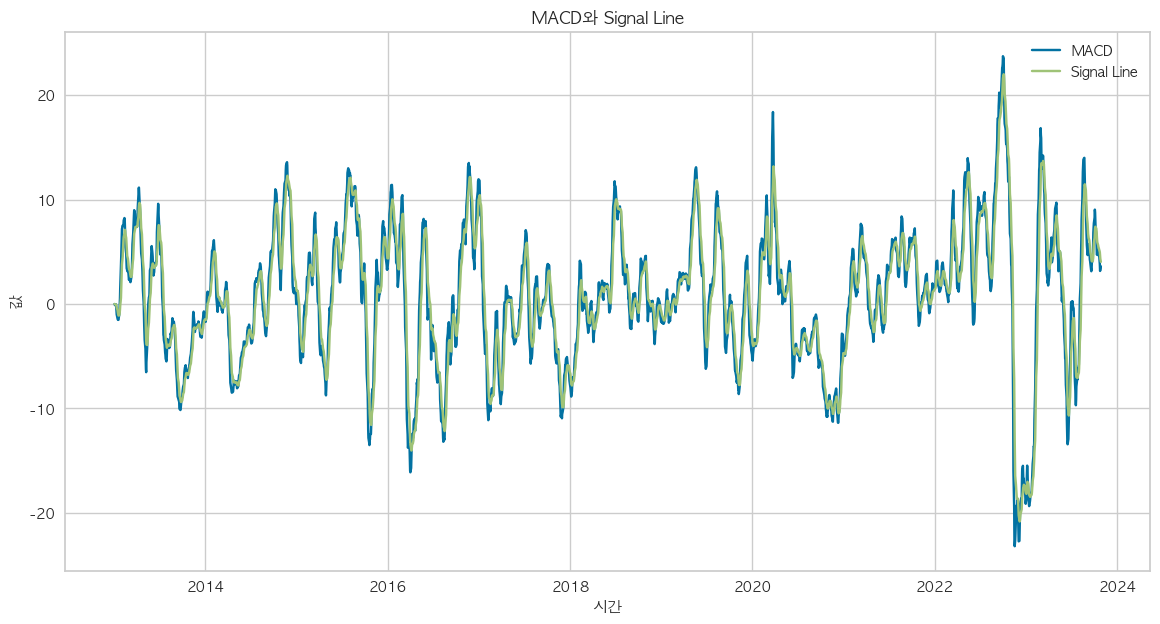

In [18]:
# 시각화 - MACD와 Signal Line
plt.figure(figsize=(14, 7))
plt.plot(df['MACD'], label='MACD')
plt.plot(df['Signal_Line'], label='Signal Line')
plt.title('MACD와 Signal Line')
plt.xlabel('시간')
plt.ylabel('값')
plt.legend()
plt.show()



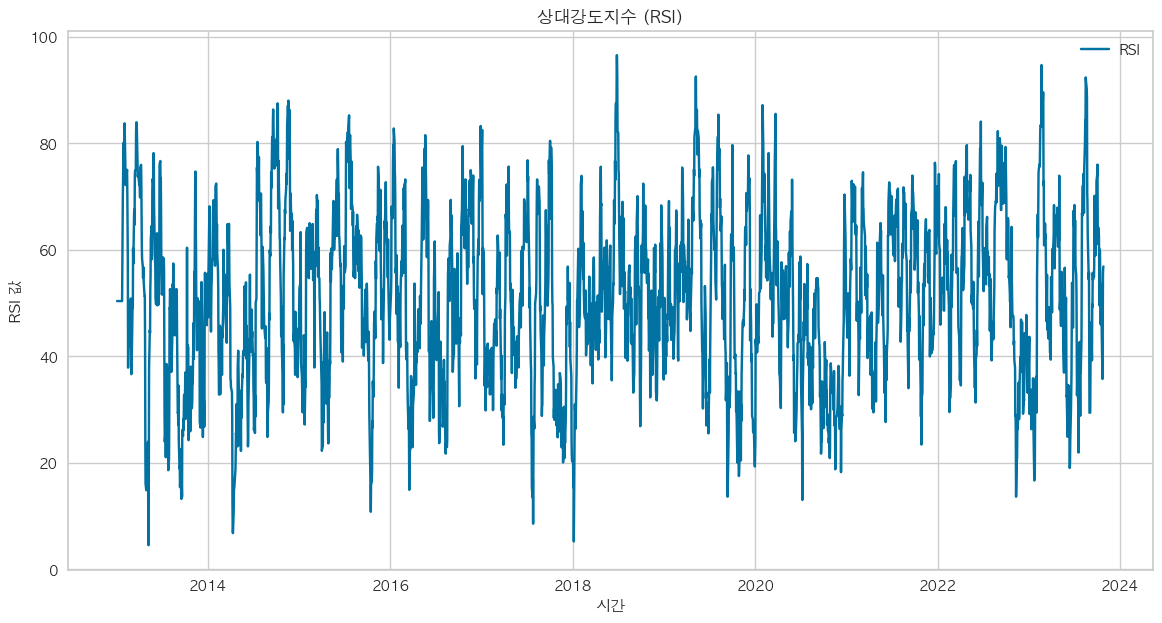

In [19]:
# 시각화 - RSI
plt.figure(figsize=(14, 7))
plt.plot(df['RSI'], label='RSI')
plt.title('상대강도지수 (RSI)')
plt.xlabel('시간')
plt.ylabel('RSI 값')
plt.legend()
plt.show()



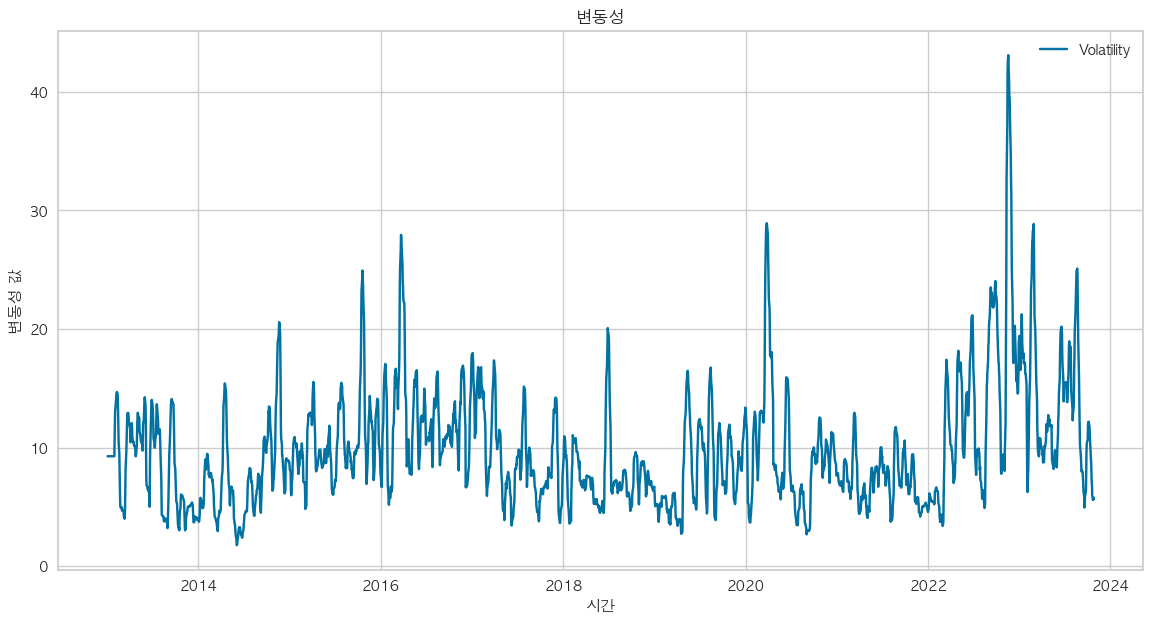

In [20]:
# 시각화 - 변동성
plt.figure(figsize=(14, 7))
plt.plot(df['Volatility'], label='Volatility')
plt.title('변동성')
plt.xlabel('시간')
plt.ylabel('변동성 값')
plt.legend()
plt.show()

# 모든 데이터를 random으로 섞음
## 시계열 데이터가 아닌 변수들의 관계만으로 USD_Price를 예측하도록 함

In [21]:
df = df.sample(frac=1).reset_index(drop=True)

In [22]:
df

,Gasoline_Price,JPY_Price,NaturalGas_Price,Gold_Price,Copper_Price,Silver_Price,AUD_Price,HKD_Price,BrentOil_Price,Platinum_Price,EUR_Price,CNY_Price,CrudeOil_Price,GBP_Price,USD_Price,MACD,Signal_Line,RSI,Volatility
0,1.9315,9.0877,2.536,1193.7,2.7330,15.889,836.87,139.770,63.45,1150.20,1163.36,174.69,56.38,1614.75,1083.25,-5.777844,-4.540741,31.117958,8.166493
1,1.7963,10.6652,3.946,1789.8,4.3200,23.791,854.97,149.690,69.51,1023.10,1372.35,179.96,67.29,1613.91,1165.28,5.282539,4.165529,60.184672,6.189395
2,1.5128,11.0223,2.871,1325.9,2.0815,18.651,849.07,144.715,49.92,1076.15,1256.99,168.25,47.64,1474.53,1122.51,-3.432570,-7.017006,60.701001,8.974128
3,1.4016,10.2798,1.956,1223.5,2.1685,15.046,880.38,148.040,38.67,959.10,1307.22,177.18,36.79,1633.06,1147.89,-16.120728,-13.464329,30.773667,22.343858
4,2.2647,9.6544,5.238,1825.4,3.8100,24.194,857.84,164.060,82.58,1002.00,1356.35,183.22,78.24,1545.67,1279.21,-17.237995,-17.529625,40.726464,16.006766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,1.5381,10.1245,2.982,1282.7,2.5640,17.581,837.28,143.515,49.47,954.80,1258.61,164.36,47.40,1443.01,1118.31,-2.972177,-3.029303,51.833143,5.750418
2776,2.4853,9.6497,5.606,1669.2,3.5245,19.486,917.71,179.950,95.69,962.50,1423.40,196.87,87.91,1642.34,1412.52,8.813780,12.438025,51.667327,9.328376
2777,1.9354,9.1122,2.684,1198.0,2.7720,16.284,846.25,139.885,63.98,1161.95,1167.03,175.01,56.71,1619.68,1084.45,-4.904114,-3.938233,36.651897,8.239759
2778,2.4575,9.3612,5.865,1713.7,3.6910,21.327,881.64,174.670,92.65,998.10,1372.78,189.29,85.83,1557.06,1371.13,-6.475443,1.065699,29.024927,19.593696


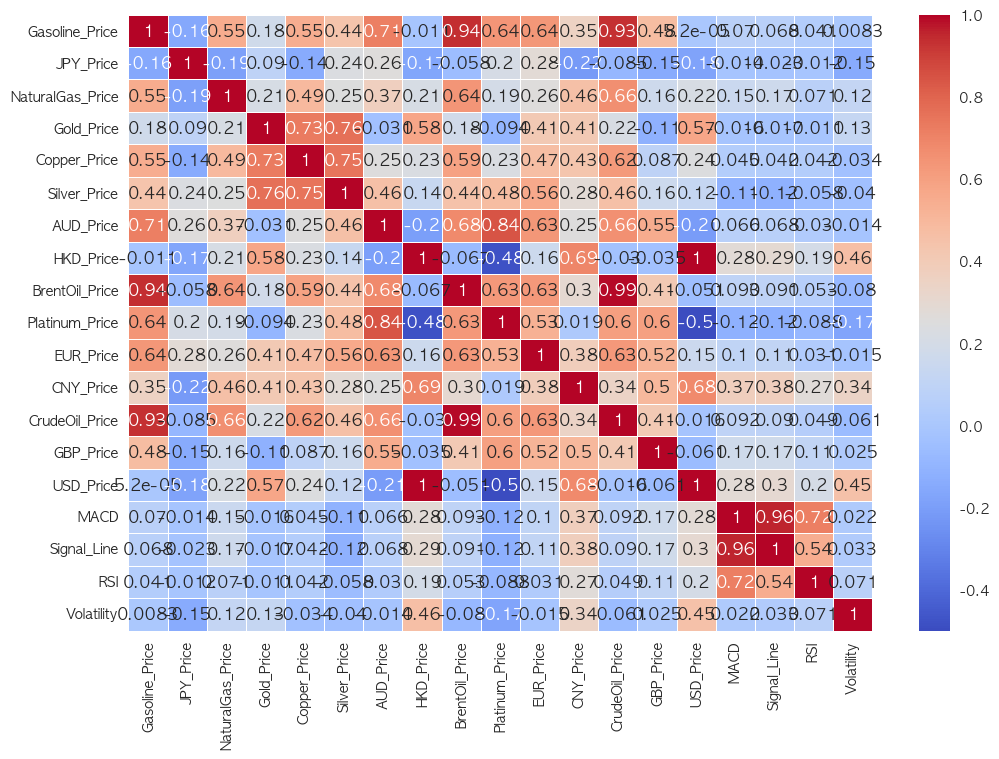

In [23]:
#상관관계 시각화
plt.figure(figsize=(12, 8))  # 히트맵의 크기 설정
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()
#plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [24]:
df

,Gasoline_Price,JPY_Price,NaturalGas_Price,Gold_Price,Copper_Price,Silver_Price,AUD_Price,HKD_Price,BrentOil_Price,Platinum_Price,EUR_Price,CNY_Price,CrudeOil_Price,GBP_Price,USD_Price,MACD,Signal_Line,RSI,Volatility
0,1.9315,9.0877,2.536,1193.7,2.7330,15.889,836.87,139.770,63.45,1150.20,1163.36,174.69,56.38,1614.75,1083.25,-5.777844,-4.540741,31.117958,8.166493
1,1.7963,10.6652,3.946,1789.8,4.3200,23.791,854.97,149.690,69.51,1023.10,1372.35,179.96,67.29,1613.91,1165.28,5.282539,4.165529,60.184672,6.189395
2,1.5128,11.0223,2.871,1325.9,2.0815,18.651,849.07,144.715,49.92,1076.15,1256.99,168.25,47.64,1474.53,1122.51,-3.432570,-7.017006,60.701001,8.974128
3,1.4016,10.2798,1.956,1223.5,2.1685,15.046,880.38,148.040,38.67,959.10,1307.22,177.18,36.79,1633.06,1147.89,-16.120728,-13.464329,30.773667,22.343858
4,2.2647,9.6544,5.238,1825.4,3.8100,24.194,857.84,164.060,82.58,1002.00,1356.35,183.22,78.24,1545.67,1279.21,-17.237995,-17.529625,40.726464,16.006766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,1.5381,10.1245,2.982,1282.7,2.5640,17.581,837.28,143.515,49.47,954.80,1258.61,164.36,47.40,1443.01,1118.31,-2.972177,-3.029303,51.833143,5.750418
2776,2.4853,9.6497,5.606,1669.2,3.5245,19.486,917.71,179.950,95.69,962.50,1423.40,196.87,87.91,1642.34,1412.52,8.813780,12.438025,51.667327,9.328376
2777,1.9354,9.1122,2.684,1198.0,2.7720,16.284,846.25,139.885,63.98,1161.95,1167.03,175.01,56.71,1619.68,1084.45,-4.904114,-3.938233,36.651897,8.239759
2778,2.4575,9.3612,5.865,1713.7,3.6910,21.327,881.64,174.670,92.65,998.10,1372.78,189.29,85.83,1557.06,1371.13,-6.475443,1.065699,29.024927,19.593696


In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
# 특징과 타겟 분할
# StandardScaler 객체 생성
scaler = StandardScaler()

# 전체 데이터를 정규화
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [27]:
from pycaret.regression import *


In [28]:
# PyCaret 환경 설정
df = setup(data=df, target='USD_Price', session_id=42, normalize=True)


,Description,Value
0,Session id,42
1,Target,USD_Price
2,Target type,Regression
3,Original data shape,"(2780, 19)"
4,Transformed data shape,"(2780, 19)"
5,Transformed train set shape,"(1945, 19)"
6,Transformed test set shape,"(835, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


In [29]:
# 모델 비교
best_model = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0103,0.0002,0.0158,0.9997,0.0094,0.0983,0.0840
lightgbm,Light Gradient Boosting Machine,0.0145,0.0006,0.0231,0.9994,0.0117,0.0829,0.4200
gbr,Gradient Boosting Regressor,0.0190,0.0006,0.0248,0.9994,0.0156,0.1950,0.1270
rf,Random Forest Regressor,0.0165,0.0006,0.0252,0.9994,0.0152,0.1890,0.2080
xgboost,Extreme Gradient Boosting,0.0175,0.0007,0.0262,0.9993,0.0142,0.1026,0.0370
huber,Huber Regressor,0.0258,0.0012,0.0341,0.9988,0.0224,0.1670,0.0100
dt,Decision Tree Regressor,0.0224,0.0012,0.0349,0.9988,0.0214,0.2546,0.0080
lr,Linear Regression,0.0264,0.0012,0.0338,0.9988,0.0221,0.1636,0.2560
br,Bayesian Ridge,0.0264,0.0012,0.0338,0.9988,0.0221,0.1636,0.0060
ridge,Ridge Regression,0.0264,0.0012,0.0339,0.9988,0.0222,0.1661,0.0050


In [40]:
dt_model = create_model('dt')

params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_tuned = tune_model(dt_model, custom_grid=params)
dt_final = finalize_model(dt_tuned)
print(predict_model(dt_final))


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0214,0.0011,0.0336,0.9990,0.0201,0.0547
1,0.0273,0.0019,0.0432,0.9980,0.0287,0.5616
2,0.0191,0.0010,0.0314,0.9990,0.0179,1.1657
3,0.0223,0.0016,0.0399,0.9986,0.0208,0.0883
4,0.0221,0.0011,0.0328,0.9988,0.0207,0.1792
5,0.0221,0.0012,0.0342,0.9988,0.0225,0.1106
6,0.0216,0.0009,0.0304,0.9992,0.0174,0.0602
7,0.0228,0.0012,0.0351,0.9985,0.0230,0.1507
8,0.0251,0.0014,0.0375,0.9986,0.0234,0.0966


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0229,0.0012,0.0350,0.9989,0.0211,0.0590
1,0.0256,0.0016,0.0399,0.9983,0.0269,0.4986
2,0.0192,0.0010,0.0311,0.9990,0.0181,0.5634
3,0.0241,0.0016,0.0403,0.9986,0.0210,0.0917
4,0.0206,0.0010,0.0321,0.9989,0.0211,0.1842
5,0.0229,0.0013,0.0354,0.9987,0.0224,0.0902
6,0.0218,0.0010,0.0317,0.9991,0.0175,0.0609
7,0.0221,0.0011,0.0328,0.9987,0.0215,0.1392
8,0.0254,0.0016,0.0395,0.9985,0.0246,0.0812


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Decision Tree Regression Evaluation


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,0.0109,0.0005,0.0214,0.9995,0.0137,0.0438


      Gasoline_Price  JPY_Price  NaturalGas_Price  Gold_Price  Copper_Price  \
1561        0.553005   0.213474          0.899880    1.180050      2.033905   
1099       -0.947334   1.303298         -0.850292   -0.156626     -0.677671   
1455       -0.569230  -0.293134         -0.300871   -0.617377      0.169557   
911         1.888360  -1.254786          4.142499    1.340280      1.893818   
521         0.406560  -1.111354          1.740258    1.144087      0.980272   
...              ...        ...               ...         ...           ...   
2102        1.361430   1.880289          0.156242   -0.899738     -0.100930   
941        -0.988325  -1.256861         -0.777922   -1.382565     -1.322965   
647        -0.518544  -0.915911         -0.471457   -0.811077     -0.120304   
2444        0.725984  -0.675869          3.521446    1.176846      0.562992   
1017        1.727117   0.131534          0.924250   -0.461775     -0.258155   

      Silver_Price  AUD_Price  HKD_Price  BrentOil_

In [33]:
rf_model = create_model('rf')
rf_tuned = tune_model(rf_model)
rf_final = finalize_model(rf_tuned)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0171,0.0007,0.0257,0.9994,0.0160,0.0524
1,0.0191,0.0009,0.0300,0.9990,0.0183,0.4271
2,0.0140,0.0005,0.0217,0.9995,0.0131,0.6792
3,0.0174,0.0009,0.0302,0.9992,0.0149,0.0549
4,0.0162,0.0005,0.0223,0.9995,0.0152,0.3153
5,0.0157,0.0006,0.0236,0.9994,0.0148,0.0627
6,0.0155,0.0006,0.0247,0.9995,0.0118,0.0384
7,0.0183,0.0008,0.0278,0.9991,0.0177,0.1213
8,0.0161,0.0005,0.0232,0.9995,0.0151,0.0716


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0471,0.0048,0.0692,0.9956,0.0365,0.1415
1,0.0510,0.0046,0.0682,0.9949,0.0412,0.5531
2,0.0430,0.0033,0.0575,0.9968,0.0327,1.2558
3,0.0514,0.0068,0.0827,0.9941,0.0372,0.3076
4,0.0481,0.0042,0.0650,0.9954,0.0386,0.3362
5,0.0433,0.0037,0.0608,0.9962,0.0352,0.1694
6,0.0491,0.0051,0.0714,0.9956,0.0340,0.1147
7,0.0436,0.0035,0.0593,0.9957,0.0347,0.2751
8,0.0458,0.0039,0.0626,0.9962,0.0370,0.2513


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [34]:
print(predict_model(rf_final))

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0111,0.0003,0.0160,0.9997,0.0096,0.0483


      Gasoline_Price  JPY_Price  NaturalGas_Price  Gold_Price  Copper_Price  \
1561        0.553005   0.213474          0.899880    1.180050      2.033905   
1099       -0.947334   1.303298         -0.850292   -0.156626     -0.677671   
1455       -0.569230  -0.293134         -0.300871   -0.617377      0.169557   
911         1.888360  -1.254786          4.142499    1.340280      1.893818   
521         0.406560  -1.111354          1.740258    1.144087      0.980272   
...              ...        ...               ...         ...           ...   
2102        1.361430   1.880289          0.156242   -0.899738     -0.100930   
941        -0.988325  -1.256861         -0.777922   -1.382565     -1.322965   
647        -0.518544  -0.915911         -0.471457   -0.811077     -0.120304   
2444        0.725984  -0.675869          3.521446    1.176846      0.562992   
1017        1.727117   0.131534          0.924250   -0.461775     -0.258155   

      Silver_Price  AUD_Price  HKD_Price  BrentOil_

In [41]:
rf_model = create_model('rf')

# 하이퍼파라미터 조정
params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_tuned = tune_model(rf_model, custom_grid=params)
rf_final = finalize_model(rf_tuned)

print(predict_model(rf_final))


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0171,0.0007,0.0257,0.9994,0.0160,0.0524
1,0.0191,0.0009,0.0300,0.9990,0.0183,0.4271
2,0.0140,0.0005,0.0217,0.9995,0.0131,0.6792
3,0.0174,0.0009,0.0302,0.9992,0.0149,0.0549
4,0.0162,0.0005,0.0223,0.9995,0.0152,0.3153
5,0.0157,0.0006,0.0236,0.9994,0.0148,0.0627
6,0.0155,0.0006,0.0247,0.9995,0.0118,0.0384
7,0.0183,0.0008,0.0278,0.9991,0.0177,0.1213
8,0.0161,0.0005,0.0232,0.9995,0.0151,0.0716


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0173,0.0007,0.0260,0.9994,0.0159,0.0544
1,0.0194,0.0009,0.0301,0.9990,0.0182,0.4112
2,0.0147,0.0005,0.0223,0.9995,0.0136,0.7083
3,0.0172,0.0009,0.0302,0.9992,0.0149,0.0594
4,0.0170,0.0005,0.0232,0.9994,0.0158,0.3012
5,0.0160,0.0006,0.0237,0.9994,0.0151,0.0606
6,0.0162,0.0007,0.0256,0.9994,0.0121,0.0402
7,0.0186,0.0008,0.0279,0.9991,0.0180,0.1227
8,0.0166,0.0005,0.0233,0.9995,0.0152,0.0688


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Random Forest Regression Evaluation


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0111,0.0003,0.0160,0.9997,0.0096,0.0483


      Gasoline_Price  JPY_Price  NaturalGas_Price  Gold_Price  Copper_Price  \
1561        0.553005   0.213474          0.899880    1.180050      2.033905   
1099       -0.947334   1.303298         -0.850292   -0.156626     -0.677671   
1455       -0.569230  -0.293134         -0.300871   -0.617377      0.169557   
911         1.888360  -1.254786          4.142499    1.340280      1.893818   
521         0.406560  -1.111354          1.740258    1.144087      0.980272   
...              ...        ...               ...         ...           ...   
2102        1.361430   1.880289          0.156242   -0.899738     -0.100930   
941        -0.988325  -1.256861         -0.777922   -1.382565     -1.322965   
647        -0.518544  -0.915911         -0.471457   -0.811077     -0.120304   
2444        0.725984  -0.675869          3.521446    1.176846      0.562992   
1017        1.727117   0.131534          0.924250   -0.461775     -0.258155   

      Silver_Price  AUD_Price  HKD_Price  BrentOil_

In [42]:
lr_model = create_model('ridge')

# 하이퍼파라미터 조정
params = {
    'alpha': [0.1, 1, 10, 100]
}

lr_tuned = tune_model(lr_model, custom_grid=params)
lr_final = finalize_model(lr_tuned)
print(predict_model(lr_final))


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0234,0.0009,0.0298,0.9992,0.0195,0.0784
1,0.0295,0.0015,0.0392,0.9983,0.0252,0.2595
2,0.0254,0.0010,0.0322,0.9990,0.0219,0.2457
3,0.0256,0.0011,0.0329,0.9991,0.0214,0.1766
4,0.0283,0.0013,0.0362,0.9986,0.0235,0.2897
5,0.0256,0.0011,0.0332,0.9989,0.0221,0.0993
6,0.0279,0.0012,0.0350,0.9990,0.0223,0.0742
7,0.0269,0.0013,0.0360,0.9984,0.0245,0.1884
8,0.0264,0.0010,0.0324,0.9990,0.0207,0.1395


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0235,0.0009,0.0298,0.9992,0.0194,0.0788
1,0.0295,0.0016,0.0396,0.9983,0.0253,0.2576
2,0.0253,0.0010,0.0321,0.9990,0.0218,0.2181
3,0.0256,0.0011,0.0330,0.9991,0.0215,0.1838
4,0.0282,0.0013,0.0360,0.9986,0.0233,0.2878
5,0.0255,0.0011,0.0332,0.9989,0.0220,0.0996
6,0.0276,0.0012,0.0348,0.9990,0.0222,0.0740
7,0.0269,0.0013,0.0359,0.9984,0.0244,0.1890
8,0.0263,0.0010,0.0324,0.9990,0.0207,0.1407


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Linear Regression (Ridge) Evaluation


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0261,0.0012,0.0341,0.9988,0.0217,0.0979


      Gasoline_Price  JPY_Price  NaturalGas_Price  Gold_Price  Copper_Price  \
1561        0.553005   0.213474          0.899880    1.180050      2.033905   
1099       -0.947334   1.303298         -0.850292   -0.156626     -0.677671   
1455       -0.569230  -0.293134         -0.300871   -0.617377      0.169557   
911         1.888360  -1.254786          4.142499    1.340280      1.893818   
521         0.406560  -1.111354          1.740258    1.144087      0.980272   
...              ...        ...               ...         ...           ...   
2102        1.361430   1.880289          0.156242   -0.899738     -0.100930   
941        -0.988325  -1.256861         -0.777922   -1.382565     -1.322965   
647        -0.518544  -0.915911         -0.471457   -0.811077     -0.120304   
2444        0.725984  -0.675869          3.521446    1.176846      0.562992   
1017        1.727117   0.131534          0.924250   -0.461775     -0.258155   

      Silver_Price  AUD_Price  HKD_Price  BrentOil_

In [43]:
# XGBoost Regression with hyperparameter tuning
xgboost_model = create_model('xgboost')

# 하이퍼파라미터 조정
params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [100, 200, 500]
}

xgboost_tuned = tune_model(xgboost_model, custom_grid=params)
xgboost_final = finalize_model(xgboost_tuned)
print("XGBoost Regression Evaluation")
print(predict_model(xgboost_final))


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0166,0.0006,0.0238,0.9995,0.0133,0.0465
1,0.0184,0.0008,0.0276,0.9992,0.0149,0.2571
2,0.0170,0.0007,0.0272,0.9993,0.0132,0.0576
3,0.0183,0.0008,0.0279,0.9993,0.0144,0.0875
4,0.0170,0.0006,0.0255,0.9993,0.0152,0.2444
5,0.0171,0.0006,0.0236,0.9994,0.0145,0.0828
6,0.0179,0.0009,0.0297,0.9992,0.0127,0.0388
7,0.0192,0.0008,0.0282,0.9990,0.0163,0.1030
8,0.0165,0.0005,0.0233,0.9995,0.0131,0.0497


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0150,0.0004,0.0211,0.9996,0.0118,0.0519
1,0.0174,0.0007,0.0269,0.9992,0.0139,0.1751
2,0.0162,0.0005,0.0221,0.9995,0.0131,0.5252
3,0.0152,0.0004,0.0206,0.9996,0.0118,0.0584
4,0.0153,0.0005,0.0213,0.9995,0.0128,0.1917
5,0.0152,0.0004,0.0202,0.9996,0.0124,0.0544
6,0.0169,0.0007,0.0265,0.9994,0.0117,0.0361
7,0.0171,0.0005,0.0232,0.9993,0.0146,0.0986
8,0.0153,0.0004,0.0208,0.9996,0.0131,0.0509


Fitting 10 folds for each of 10 candidates, totalling 100 fits
XGBoost Regression Evaluation


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0154,0.0004,0.0207,0.9996,0.0123,0.0555


      Gasoline_Price  JPY_Price  NaturalGas_Price  Gold_Price  Copper_Price  \
1561        0.553005   0.213474          0.899880    1.180050      2.033905   
1099       -0.947334   1.303298         -0.850292   -0.156626     -0.677671   
1455       -0.569230  -0.293134         -0.300871   -0.617377      0.169557   
911         1.888360  -1.254786          4.142499    1.340280      1.893818   
521         0.406560  -1.111354          1.740258    1.144087      0.980272   
...              ...        ...               ...         ...           ...   
2102        1.361430   1.880289          0.156242   -0.899738     -0.100930   
941        -0.988325  -1.256861         -0.777922   -1.382565     -1.322965   
647        -0.518544  -0.915911         -0.471457   -0.811077     -0.120304   
2444        0.725984  -0.675869          3.521446    1.176846      0.562992   
1017        1.727117   0.131534          0.924250   -0.461775     -0.258155   

      Silver_Price  AUD_Price  HKD_Price  BrentOil_